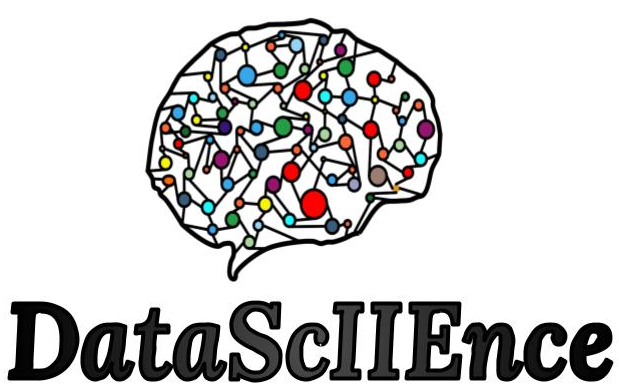


# Computer Vision

* La vision par ordinateur est une branche de l’intelligence artificielle qui traite de la façon dont les ordinateurs peuvent acquérir une compréhension de haut niveau à partir d'images ou de vidéos numériques.

* Du point de vue de l'ingénierie, il cherche à comprendre et à automatiser les tâches que le système visuel humain peut effectuer.

![cv](https://blog.deloitte.fr/wp-content/uploads/2019/02/computer-vision-blog.png)

## YOLO

### Introduction au modèle

* ```YOLOv7``` (**You Only Look Once**) est un modèle Open Source de référence pour la détection automatique d’objets.

* Il constitue la 7ème version du framework ```YOLO``` proposé en 2015 par Joseph Redmond, Santosh Divvala, Ross Girshick et Ali Farhadi [ici](https://arxiv.org/abs/1506.02640) !

* ```YOLO``` est un modèle complet qui combine la détection de l’objet et la classification.

* Dans ce qui suit on va utiliser ```YOLOv3``` parce qu'il est entièrement suffisant pour ce qu'on va faire.

### Comment ça marche ?

* Dans le cas de l’analyse d’une vidéo, la séquence est découpée en plusieurs images. L’idée est ensuite d’analyser l’image avec un réseau de neurones (on abordera plus spécialement le sujet des réseaux de neurones durant la prochaine formation).

* On découpe ensuite l’image en plusieurs petites régions et on applique le système de détection à chaque fois.

* Le système encadre la région, lui donne un label à partir des données d’entraînements et calcul un score de confiance de sa prédiction.

![yolo](https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/60edcdbb660bc4adc635f744_P9709u0H-JwS5jCaxiFCdr0_HQnbe3dExzj7Nq_fkcL3HIFTsBGt2uTWA89fLVcZik5dBjVw5BRlSy5KooKI-tXCXmPJ1aLHVxOcr-YLxGKbVwBrxjWKCCo8TUV90TgB37tmkpMz.png)

* Pour les plus curieux d'entre vous voici à quoi ressemble le réseau de neurones convolutionnels de Yolo :

![yolores](https://www.researchgate.net/profile/Rui-Jiang-11/publication/312593672/figure/fig1/AS:454309071593483@1485327131630/Convolutional-neural-network-of-the-YOLO-Model.png)

## Détection d'objets

* On importe d'abord les libraries nécessaires

In [1]:
import numpy as np
import cv2

* On se connecte à Google Drive où est stocker le modèle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### YOLO loading

In [3]:
# loading the network
net = cv2.dnn.readNet("/content/drive/MyDrive/yolo/yolov3.weights", "/content/drive/MyDrive/yolo/yolov3.cfg")

In [4]:
# loading the classes
classes = []
with open("/content/drive/MyDrive/yolo/coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

In [5]:
# loading layers and colors
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
colors = np.random.uniform(0, 255, size=(len(classes), 3))

#### Image loading

In [9]:
# saving the image
img = cv2.imread("/content/input-yolo1.jpg")

In [10]:
# changing size of image
img = cv2.resize(img, None, fx=1.3, fy=1.3)

In [11]:
# getting shape informations
img_height, img_width, channels = img.shape

#### Détection

In [12]:
# binary large object of image
blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

In [13]:
# putting the image blob on the network
net.setInput(blob)

In [14]:
# saving the output of the network
outputs = net.forward(output_layers)

In [15]:
# list of classes index
class_ids = []
# list of classes confidences
confidences = []
# list of classes boxes
boxes = []
# iterating over the detections
for output in outputs:
    for detection in output:
        # saving the index and the confidence of the detected class
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            # coordinates of the object detected
            center_x = int(detection[0] * img_width)
            center_y = int(detection[1] * img_height)
            width = int(detection[2] * img_width)
            height = int(detection[3] * img_height)
            # coordinates of the rectangle box 
            x = int(center_x - width / 2)
            y = int(center_y - height / 2)
            boxes.append([x, y, width, height])
            confidences.append(float(confidence))
            class_ids.append(class_id)
# indexs for boxes and classes
indexs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

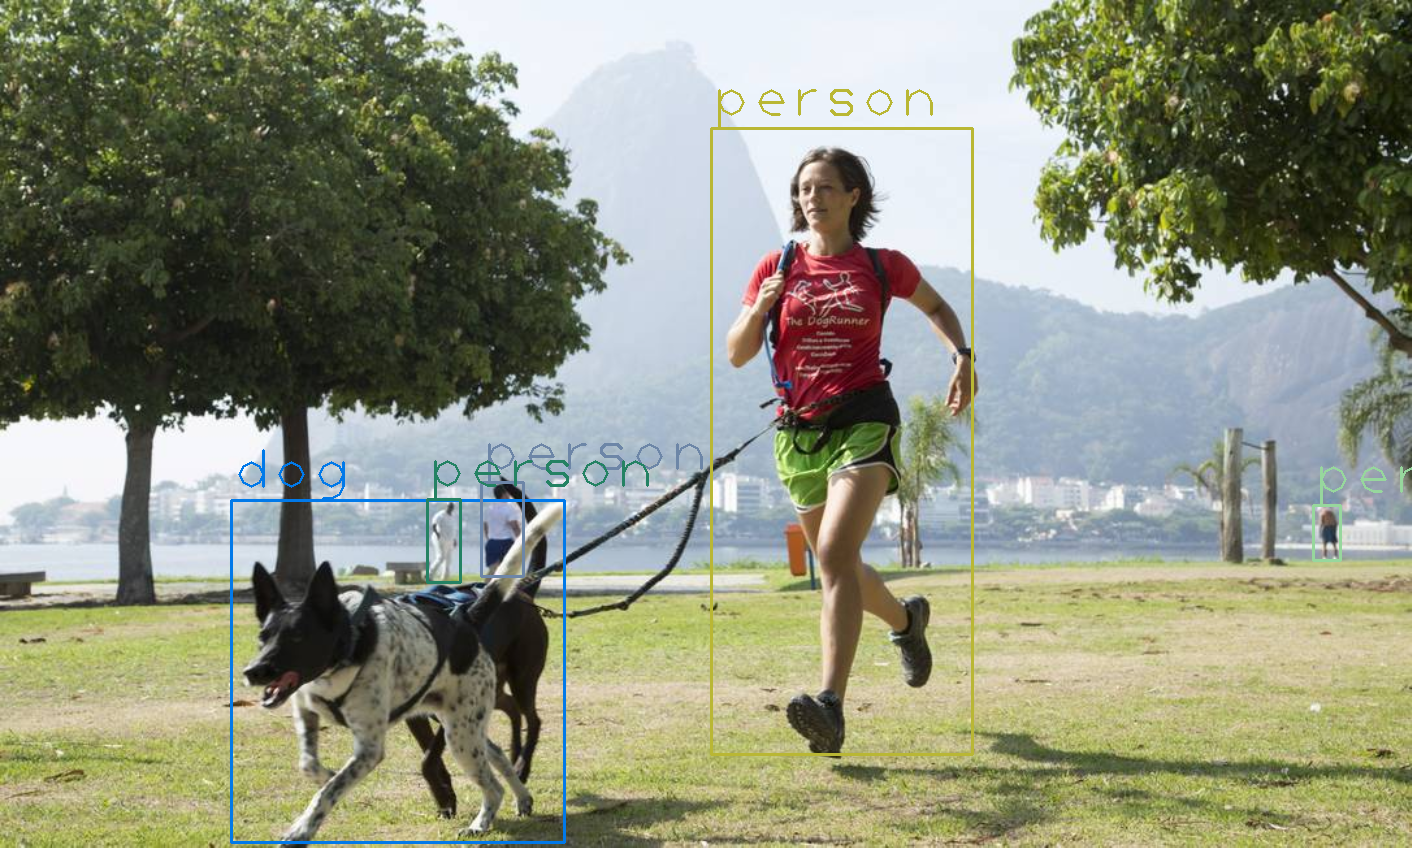

In [16]:
# using a patch because colab doesn't support cv2.imshow()
from google.colab.patches import cv2_imshow
# choosing a font for text
font = cv2.FONT_HERSHEY_PLAIN
# iterating over the boxes
for i in range(len(boxes)):
    # verifying if the index is in our list
    if i in indexs:
        # positions of the box
        x, y, w, h = boxes[i]
        # name of the class detected
        label = str(classes[class_ids[i]])
        # color to use for rectangle and text
        color = colors[i]
        # drawing the rectangle on the image
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        # writing the text on the image
        cv2.putText(img, label, (x, y - 10), font, 4, color, 2)
# showing the image
cv2_imshow(img)

## OpenPose

### Introduction au modèle

* L’estimation de poses est une technique de computer vision qui permet de détecter la posture d’une personne sur une image ou une vidéo, afin d’en extraire un modèle biomécanique.

* Deux approches existent pour l’estimation de poses dans un contexte multi-person (lorsque plusieurs personnes sont présentes à l’image) :

  * Dans la première approche, dites descendante (top-down), le modèle commence d’abord par détecter et localiser les personnes présentes à l’image, puis extrait la pose pour chaque personne en analysant seulement la partie de l’image dans laquelle cette personne est visible, comme pour une extraction dans un contexte single-person.

  * La seconde approche est l’approche ascendante (bottom-up). Elle consiste à localiser des articulations du corps humain de façon isolée, puis les assemble en pose à l’aide d’un modèle d’association.

![openpose](https://miro.medium.com/max/1400/1*nO5pkBT9pf7sIWGw8o7cGg.png)

### Comment ça marche ?

* Le modèle prend une image en entrée et il est composé de deux parties :

  * La première partie joue le rôle d’encodeur et va permettre, en utilisant des réseaux de neurones de convolution, d’extraire des caractéristiques sous la forme d’un vecteur.

  * La deuxième partie, qui est un modèle de régression, joue le rôle de décodeur et permet d’estimer la pose de la personne à partir du vecteur de ses caractéristiques.

![openposenet](https://larevueia.fr/wp-content/uploads/2021/12/encoder_decoder_pose-1.png)

## Détection de poses

#### OpenPose loading

**NB** : le modèle est assez lourd et prend en général 15 minutes à se charger

In [17]:
import os
import io
import base64
from IPython.display import YouTubeVideo, HTML
from os.path import exists, join, basename, splitext

In [18]:
repo_git_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(repo_git_url))[0]
if not exists(project_name):
  # installing new CMake because of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # cloning openpose repository
  !git clone -q --depth 1 $repo_git_url
  !cd openpose/ubuntu && ./install_cmake.sh && ./install_cuda.sh && ./install_cudnn.sh
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # installing system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # installing python dependencies
  !pip install -q youtube-dl
  # building openpose
  !cd openpose && git pull origin master && rm -r build || true && mkdir build && cd build && cmake .. && make -j`nproc```

/bin/bash: line 0: cd: openpose/ubuntu: No such file or directory
Selecting previously unselected package libgflags2.2.
(Reading database ... 155676 files and directories currently installed.)
Preparing to unpack .../00-libgflags2.2_2.2.1-1_amd64.deb ...
Unpacking libgflags2.2 (2.2.1-1) ...
Selecting previously unselected package libgflags-dev.
Preparing to unpack .../01-libgflags-dev_2.2.1-1_amd64.deb ...
Unpacking libgflags-dev (2.2.1-1) ...
Selecting previously unselected package libgoogle-glog0v5.
Preparing to unpack .../02-libgoogle-glog0v5_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog0v5 (0.3.5-1) ...
Selecting previously unselected package libgoogle-glog-dev.
Preparing to unpack .../03-libgoogle-glog-dev_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog-dev (0.3.5-1) ...
Selecting previously unselected package libhdf5-serial-dev.
Preparing to unpack .../04-libhdf5-serial-dev_1.10.0-patch1+docs-4_all.deb ...
Unpacking libhdf5-serial-dev (1.10.0-patch1+docs-4) ...
Selecting previous

#### Video download

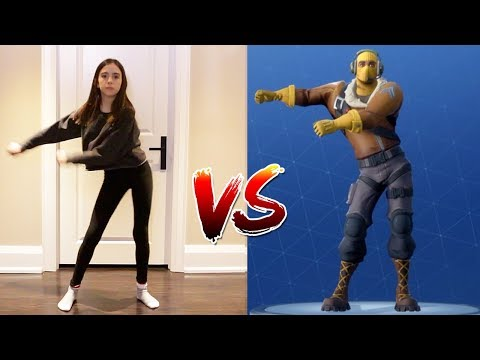

In [19]:
# saving YouTube video ID
YouTubeID = 'RXABo9hm8B8'
# opening YouTube video
YouTubeVideo(YouTubeID)

**NB** : la vidéo va mettre 30 minutes à se télécharger

In [20]:
# deleting previous input video
!rm -rf youtube.mp4
# downloading the youtube with the given ID
!youtube-dl -f 'bestvideo[ext=mp4]' --output "youtube.%(ext)s" https://www.youtube.com/watch?v=$YouTubeID
# cuting the 10 first seconds of the video
!ffmpeg -y -loglevel info -i youtube.mp4 -t 10 video.mp4

[youtube] RXABo9hm8B8: Downloading webpage
[download] Destination: youtube.mp4
[download] 100% of 115.20MiB in 24:30
ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbi

#### Détection

In [21]:
# deleting previous output video
!rm openpose.avi
# detecting poses on the these first seconds
!cd openpose && ./build/examples/openpose/openpose.bin --video ../video.mp4 --write_json ./output/ --display 0  --write_video ../openpose.avi
# converting the result into MP4
!ffmpeg -y -loglevel info -i openpose.avi output.mp4

rm: cannot remove 'openpose.avi': No such file or directory
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 25.719561 seconds.
ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-l

In [22]:
# reading the video
video_encoded = base64.b64encode(io.open('output.mp4', 'rb').read())
# displaying the video
HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
             <source src="data:video/mp4;base64,{2}" type="video/mp4" />
             </video>'''.format(960, 720, video_encoded.decode('ascii')))